In [1]:
import glob
from timeit import default_timer as timer

import numpy as np
import torch
import clip
from PIL import Image
import scipy.special

import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# CONSTANTS
"""
Choose accordingly to the Model/Dataset being evaluated:
MODEL= {ViT-L-14} 
DATASET= {PH2, derm7pt}
"""

MODEL = "ViT-L-14"
DATASET = "derm7pt"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [10]:
CLASS_LABELS_PROMPTS = {
    "Melanoma": ["This is dermatoscopy of melanoma"],
    "Nevus": ["This is dermatoscopy of nevus"]
}

In [11]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):
    """
    Similarity Score used in "Fostering transparent medical image AI via an image-text foundation model grounded in medical literature"
    https://www.medrxiv.org/content/10.1101/2023.06.07.23291119v1.full.pdf
    """
    

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [12]:
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")

# Load image embeddings 
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_MONET_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()

# Load reference embeddings
reference_embeddings = torch.from_numpy(np.load(f"reference_embeddings/reference_concept_embeddings.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        # Load text embeddings
        text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}.npy")).unsqueeze(0)

        # Calculate similarity
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=True)

        similarity_scores.append(similarity[0])

    # Save score into a dictionary w.r.t. to image
    results[im] = similarity_scores

[INFO] DATASET: derm7pt
[INFO] MODEL: ViT-L-14


In [13]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("../data/PH2/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("../data/PH2/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/PH2/PH2_train_split_0.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/PH2/PH2_test_split_0.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("../data/derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("../data/derm7pt/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/derm7pt/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/derm7pt/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()


y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold, "\n")

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if np.max(results[im]) > optimal_threshold else 0)
        y_pred_probs.append(np.max(results[im]))

print(f"Classification Report:")
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

print("Confusion Matrix:")
print(conf_matrix, "\n")

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 0.50525546 

Classification Report:
              precision    recall  f1-score   support

         MEL       0.72      0.84      0.78       219
         NEV       0.46      0.29      0.35       101

    accuracy                           0.67       320
   macro avg       0.59      0.57      0.57       320
weighted avg       0.64      0.67      0.64       320

Confusion Matrix:
[[185  34]
 [ 72  29]] 

AUC: 0.6340702563407026
BACC: 0.5659387856593878
Sensitivity: 0.2871287128712871
Specificity: 0.8447488584474886


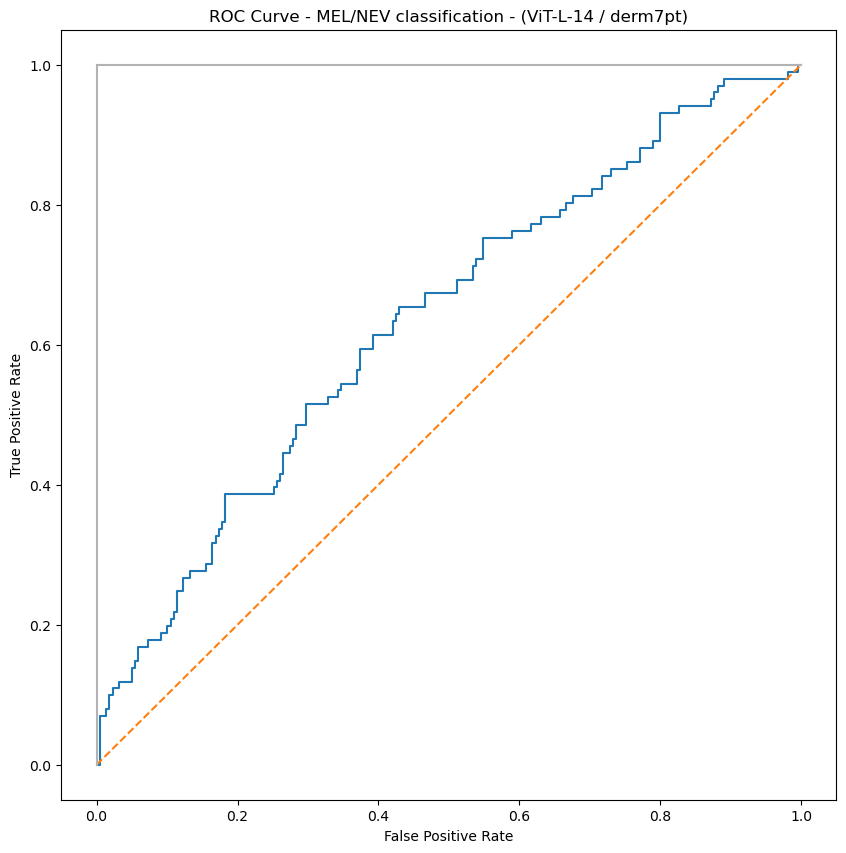

In [14]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title(f'ROC Curve - MEL/NEV classification - ({MODEL} / {DATASET})')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()